In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%capture
! pip install pandarallel -q
! pip install -U sentence-transformers -q

In [ ]:
import psutil

workers = psutil.cpu_count()
# psutil.cpu_count(logical=False)

from pandarallel.utils import progress_bars
progress_bars.is_notebook_lab = lambda : True

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=workers, use_memory_fs=False)

In [ ]:
from sentence_transformers import SentenceTransformer ,  util
import torch
import pandas as pd
import numpy as np
import string
import re
from tqdm.auto import tqdm
tqdm.pandas()

# LIAR

In [ ]:
liar = pd.read_csv("/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/LIAR/Liar_all.csv")
lexicon = pd.read_csv("/content/drive/Shareddrives/[FYP] Fake News Detection/Results/LIAR/Liar_lexicon.csv")
semantic = pd.read_csv("/content/drive/Shareddrives/[FYP] Fake News Detection/Results/LIAR/Liar_sementic.csv")
emotions = pd.read_csv("/content/drive/Shareddrives/[FYP] Fake News Detection/Results/LIAR/LIAR_predictions_emotions.csv")

In [ ]:
# dff_1 = liar.join(lexicon.set_index('ID'), on='ID', how='left')
# dff_2 = semantic.join(emotions.set_index('ID'), on='ID', how='left')

dff_1 = liar.merge(lexicon, how='inner', on='ID', suffixes=('_liar', '_lexicon'))
dff_2 = semantic.merge(emotions, how='inner', on='ID', suffixes=('_semantic', '_emotions'))

dff = dff_1.merge(dff_2, how='inner', on='ID')

In [ ]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12765 entries, 0 to 12764
Data columns (total 56 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ID                                     12765 non-null  object 
 1   label                                  12765 non-null  object 
 2   statement                              12765 non-null  object 
 3   subject(s)                             12763 non-null  object 
 4   speaker                                12763 non-null  object 
 5   speaker_job_title                      9201 non-null   object 
 6   state                                  10017 non-null  object 
 7   party                                  12763 non-null  object 
 8   credit_history_count_barely_true       12763 non-null  float64
 9   credit_history_count_false             12763 non-null  float64
 10  credit_history_count_half_true         12763 non-null  float64
 11  cr

In [ ]:
dff = dff[['ID', 'statement', 'label', 'split', 'fake_score', 'true_score', 'common_score',
           'joy', 'fear', 'disgust', 'anticipation', 'anger', 'sadness', 'surprise', 'trust',
           'url_count', 'qn_symbol', 'num_chars', 'num_words', 'num_sentences', 'words_per_sentence', 'characters_per_word', 
           'punctuations_per_sentence', 'num_exclamation', 'get_sentiment_polarity', 'lexical_diversity', 'content_word_diversity',
           'redundancy', 'noun', 'verb', 'adj', 'adv']]

dff["qn_symbol_per_sentence"]=dff["qn_symbol"]/dff["num_sentences"]
dff["num_exclamation_per_sentence"]=dff["num_exclamation"]/dff["num_sentences"]
dff["url_count_per_sentence"]=dff["url_count"]/dff["num_sentences"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [ ]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12765 entries, 0 to 12764
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            12765 non-null  object 
 1   statement                     12765 non-null  object 
 2   label                         12765 non-null  object 
 3   split                         12765 non-null  object 
 4   fake_score                    12765 non-null  float64
 5   true_score                    12765 non-null  float64
 6   common_score                  12765 non-null  float64
 7   joy                           12765 non-null  float64
 8   fear                          12765 non-null  float64
 9   disgust                       12765 non-null  float64
 10  anticipation                  12765 non-null  float64
 11  anger                         12765 non-null  float64
 12  sadness                       12765 non-null  float64
 13  s

In [ ]:
%%capture
# Import the sentence transformer model
model = SentenceTransformer('ghanashyamvtatti/roberta-fake-news', device = 'cuda')

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/ghanashyamvtatti_roberta-fake-news were not used when initializing RobertaModel: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /root/.cache/torch/sentence_transformers/ghanashyamvtatti_roberta-fake-news and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN

In [ ]:
def lower(text):
  return text.lower()

# remove urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_nonascii(sent):
  return "".join([i for i in sent if i.isascii()])

def remove_punctuations(text):
  # text = text.translate(str.maketrans('', ' ', string.punctuation))
  # return text

  res = re.sub(r'[^\w\s]', '', text)
  return res

def remove_num(text):
  return "".join([c for c in text if not c.isdigit()])

# remove multiple spaces
def remove_mul_space(text):
  return " ".join(text.split())

def clean(text):
  
  text = lower(text)
  text = remove_urls(text)
  text = remove_nonascii(text)
  text = remove_punctuations(text)
  text = remove_num(text)
  text = remove_mul_space(text)

  return text

def generate_embeddings(sentences):
  
  embeddings = model.encode(sentences=sentences, show_progress_bar=True)
  embeddings=[torch.from_numpy(item) for item in embeddings]
  
  return embeddings

def convert_to_array(tensor):
  return tensor.detach().cpu().numpy().tolist()

def get_tokens(text):
  return len(re.findall(r'\w+', text))

In [ ]:
dff['statement'] = dff['statement'].parallel_apply(clean)

In [ ]:
statements = dff['statement'].tolist()
embeddings = generate_embeddings(statements)
dff['embedding'] = embeddings
dff['embedding'] = dff['embedding'].parallel_apply(convert_to_array)

Batches:   0%|          | 0/399 [00:00<?, ?it/s]

In [ ]:
dff["label"]=dff["label"].replace(["true","mostly-true","half-true"],0)
dff["label"]=dff["label"].replace(["false","barely-true","pants-fire"],1)

In [ ]:
X_train_2 = dff.loc[dff["split"]=="train"][['fake_score', 'true_score', 'common_score',
           'joy', 'fear', 'disgust', 'anticipation', 'anger', 'sadness', 'surprise', 'trust',
           'url_count', 'qn_symbol', 'num_chars', 'num_words', 'num_sentences', 'words_per_sentence', 'characters_per_word', 
           'punctuations_per_sentence', 'num_exclamation', 'get_sentiment_polarity', 'lexical_diversity', 'content_word_diversity',
           'redundancy', 'noun', 'verb', 'adj', 'adv', 'qn_symbol_per_sentence', 'num_exclamation_per_sentence',
           'url_count_per_sentence', 'embedding']].to_numpy().tolist()
X_valid_2 = dff.loc[dff["split"]=="valid"][['fake_score', 'true_score', 'common_score',
           'joy', 'fear', 'disgust', 'anticipation', 'anger', 'sadness', 'surprise', 'trust',
           'url_count', 'qn_symbol', 'num_chars', 'num_words', 'num_sentences', 'words_per_sentence', 'characters_per_word', 
           'punctuations_per_sentence', 'num_exclamation', 'get_sentiment_polarity', 'lexical_diversity', 'content_word_diversity',
           'redundancy', 'noun', 'verb', 'adj', 'adv', 'qn_symbol_per_sentence', 'num_exclamation_per_sentence',
           'url_count_per_sentence', 'embedding']].to_numpy().tolist()
X_test_2 = dff.loc[dff["split"]=="test"][['fake_score', 'true_score', 'common_score',
           'joy', 'fear', 'disgust', 'anticipation', 'anger', 'sadness', 'surprise', 'trust',
           'url_count', 'qn_symbol', 'num_chars', 'num_words', 'num_sentences', 'words_per_sentence', 'characters_per_word', 
           'punctuations_per_sentence', 'num_exclamation', 'get_sentiment_polarity', 'lexical_diversity', 'content_word_diversity',
           'redundancy', 'noun', 'verb', 'adj', 'adv', 'qn_symbol_per_sentence', 'num_exclamation_per_sentence',
           'url_count_per_sentence', 'embedding']].to_numpy().tolist()

y_train_2 = dff.loc[dff["split"] == "train"]["label"].tolist()
y_valid_2 = dff.loc[dff["split"] == "valid"]["label"].tolist()
y_test_2 = dff.loc[dff["split"] == "test"]["label"].tolist()

In [ ]:
# arr = dff[['fake_score', 'true_score', 'common_score',
#            'joy', 'fear', 'disgust', 'anticipation', 'anger', 'sadness', 'surprise', 'trust',
#            'url_count', 'qn_symbol', 'num_chars', 'num_words', 'num_sentences', 'words_per_sentence', 'characters_per_word', 
#            'punctuations_per_sentence', 'num_exclamation', 'get_sentiment_polarity', 'lexical_diversity', 'content_word_diversity',
#            'redundancy', 'noun', 'verb', 'adj', 'adv', 'qn_symbol_per_sentence', 'num_exclamation_per_sentence',
#            'url_count_per_sentence', 'embedding']].to_numpy().tolist()

In [ ]:
for i in range (len(X_train_2)):
  list_str = str(X_train_2[i]).replace("[", "").replace("]", "")
  X_train_2[i] = eval(f"[{list_str}]")
X_train_2 = np.array(X_train_2)
y_train_2 = np.array(y_train_2)

for i in range (len(X_valid_2)):
  list_str = str(X_valid_2[i]).replace("[", "").replace("]", "")
  X_valid_2[i] = eval(f"[{list_str}]")
X_valid_2 = np.array(X_valid_2)
y_valid_2 = np.array(y_valid_2)

for i in range (len(X_test_2)):
  list_str = str(X_test_2[i]).replace("[", "").replace("]", "")
  X_test_2[i] = eval(f"[{list_str}]")
X_test_2 = np.array(X_test_2)
y_test_2 = np.array(y_test_2)

In [ ]:
# len(X_valid)

In [ ]:
# first neural network with keras tutorial
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# define the keras model
model_2 = Sequential()
model_2.add(Dense(64, input_dim=799, activation='relu'))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(16, activation='relu'))
model_2.add(Dense(8, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

In [ ]:
# compile the keras model
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                51200     
                                                                 
 dense_21 (Dense)            (None, 32)                2080      
                                                                 
 dense_22 (Dense)            (None, 16)                528       
                                                                 
 dense_23 (Dense)            (None, 8)                 136       
                                                                 
 dense_24 (Dense)            (None, 1)                 9         
                                                                 
Total params: 53,953
Trainable params: 53,953
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow as tf

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    # min_delta=0,
    patience=5,
    verbose=2,
    mode="min",
    # baseline=None,
    restore_best_weights=True,
)

In [ ]:
# fit the keras model on the dataset
# model.fit(X_train, y_train, epochs=10, batch_size=16)

history = model_2.fit(X_train_2, y_train_2, batch_size=128,
              epochs=1000, 
              validation_data=(X_valid_2, y_valid_2),
            # callbacks=[callback], 
            verbose=0,
)

In [ ]:
_, accuracy = model_2.evaluate(X_test_2, y_test_2)
print('Accuracy: %.2f' % (accuracy*100))

40/40 [==============================] - 0s 4ms/step - loss: 1.2136 - accuracy: 0.5817
Accuracy: 58.17


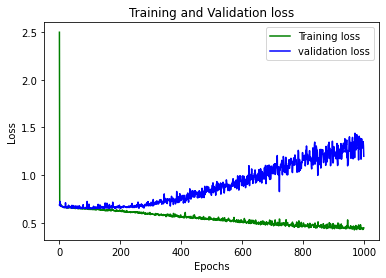

In [ ]:
import matplotlib.pyplot as plt

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1000)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# FakeNewsNet

In [ ]:
fakenewsnet = pd.read_csv(r"/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/FakeNewsNet/FakeNewsNet_All.csv")
lexicon = pd.read_csv(r"/content/drive/Shareddrives/[FYP] Fake News Detection/Results/FakeNewsNet/FakeNewsNet_lexicon.csv")
semantic = pd.read_csv(r"/content/drive/Shareddrives/[FYP] Fake News Detection/Results/FakeNewsNet/FakeNewsNet_sementic.csv")
emotions = pd.read_csv(r"/content/drive/Shareddrives/[FYP] Fake News Detection/Results/FakeNewsNet/FakeNewsNet_predictions_emotions.csv")

In [ ]:
# dff_1 = liar.join(lexicon.set_index('ID'), on='ID', how='left')
# dff_2 = semantic.join(emotions.set_index('ID'), on='ID', how='left')

dff_1 = fakenewsnet.merge(lexicon, how='inner', on='id', suffixes=('_liar', '_lexicon'))
dff_2 = semantic.merge(emotions, how='inner', on='id', suffixes=('_semantic', '_emotions'))

dff = dff_1.merge(dff_2, how='inner', on='id')

In [ ]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21721 entries, 0 to 21720
Data columns (total 50 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     21721 non-null  object 
 1   news_url                               21395 non-null  object 
 2   title                                  21721 non-null  object 
 3   tweet_ids                              20318 non-null  object 
 4   label                                  21721 non-null  object 
 5   source                                 20737 non-null  object 
 6   id_1_x                                 21721 non-null  int64  
 7   fake_score                             21721 non-null  float64
 8   true_score                             21721 non-null  float64
 9   common_score                           21721 non-null  float64
 10  label_semantic                         21721 non-null  object 
 11  so

In [ ]:
dff = dff[['id', 'title', 'label', 'fake_score', 'true_score', 'common_score',
           'joy', 'fear', 'disgust', 'anticipation', 'anger', 'sadness', 'surprise', 'trust',
           'url_count', 'qn_symbol', 'num_chars', 'num_words', 'num_sentences', 'words_per_sentence', 'characters_per_word', 
           'punctuations_per_sentence', 'num_exclamation', 'get_sentiment_polarity', 'lexical_diversity', 'content_word_diversity',
           'redundancy', 'noun', 'verb', 'adj', 'adv']]

dff["qn_symbol_per_sentence"]=dff["qn_symbol"]/dff["num_sentences"]
dff["num_exclamation_per_sentence"]=dff["num_exclamation"]/dff["num_sentences"]
dff["url_count_per_sentence"]=dff["url_count"]/dff["num_sentences"]

In [ ]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21721 entries, 0 to 21720
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            21721 non-null  object 
 1   title                         21721 non-null  object 
 2   label                         21721 non-null  object 
 3   fake_score                    21721 non-null  float64
 4   true_score                    21721 non-null  float64
 5   common_score                  21721 non-null  float64
 6   joy                           21721 non-null  float64
 7   fear                          21721 non-null  float64
 8   disgust                       21721 non-null  float64
 9   anticipation                  21721 non-null  float64
 10  anger                         21721 non-null  float64
 11  sadness                       21721 non-null  float64
 12  surprise                      21721 non-null  float64
 13  t

In [ ]:
# Import the sentence transformer model
model = SentenceTransformer('ghanashyamvtatti/roberta-fake-news', device = 'cuda')

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/ghanashyamvtatti_roberta-fake-news were not used when initializing RobertaModel: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /root/.cache/torch/sentence_transformers/ghanashyamvtatti_roberta-fake-news and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN

In [ ]:
def lower(text):
  return text.lower()

# remove urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_nonascii(sent):
  return "".join([i for i in sent if i.isascii()])

def remove_punctuations(text):
  # text = text.translate(str.maketrans('', ' ', string.punctuation))
  # return text

  res = re.sub(r'[^\w\s]', '', text)
  return res

def remove_num(text):
  return "".join([c for c in text if not c.isdigit()])

# remove multiple spaces
def remove_mul_space(text):
  return " ".join(text.split())

def clean(text):
  
  text = lower(text)
  text = remove_urls(text)
  text = remove_nonascii(text)
  text = remove_punctuations(text)
  text = remove_num(text)
  text = remove_mul_space(text)

  return text

def generate_embeddings(sentences):
  
  embeddings = model.encode(sentences=sentences, show_progress_bar=True)
  embeddings=[torch.from_numpy(item) for item in embeddings]
  
  return embeddings

def convert_to_array(tensor):
  return tensor.detach().cpu().numpy().tolist()

def get_tokens(text):
  return len(re.findall(r'\w+', text))

In [ ]:
dff['title'] = dff['title'].parallel_apply(clean)

In [ ]:
statements = dff['title'].tolist()
embeddings = generate_embeddings(statements)
dff['embedding'] = embeddings
dff['embedding'] = dff['embedding'].parallel_apply(convert_to_array)

Batches:   0%|          | 0/679 [00:00<?, ?it/s]

In [ ]:
dff['label'].unique()

array(['Fake', 'Real'], dtype=object)

In [ ]:
dff["label"]=dff["label"].replace(["Real"],0)
dff["label"]=dff["label"].replace(["Fake"],1)

In [ ]:
! pip install fast_ml -q

In [ ]:
from fast_ml.model_development import train_valid_test_split

X_train_1, y_train_1, X_valid_1, y_valid_1, X_test_1, y_test_1 = train_valid_test_split(dff[['fake_score', 'true_score', 'common_score',
           'joy', 'fear', 'disgust', 'anticipation', 'anger', 'sadness', 'surprise', 'trust',
           'url_count', 'qn_symbol', 'num_chars', 'num_words', 'num_sentences', 'words_per_sentence', 'characters_per_word', 
           'punctuations_per_sentence', 'num_exclamation', 'get_sentiment_polarity', 'lexical_diversity', 'content_word_diversity',
           'redundancy', 'noun', 'verb', 'adj', 'adv', 'qn_symbol_per_sentence', 'num_exclamation_per_sentence',
           'url_count_per_sentence', 'embedding', 'label']], target = 'label', train_size=0.8, valid_size=0.1, test_size=0.1)

In [ ]:
X_train_1 = X_train_1.to_numpy().tolist()
y_train_1 = y_train_1.to_numpy().tolist()

X_valid_1 = X_valid_1.to_numpy().tolist()
y_valid_1 = y_valid_1.to_numpy().tolist()

X_test_1 = X_test_1.to_numpy().tolist()
y_test_1 = y_test_1.to_numpy().tolist()

In [ ]:
for i in range (len(X_train_1)):
  list_str = str(X_train_1[i]).replace("[", "").replace("]", "")
  X_train_1[i] = eval(f"[{list_str}]")
X_train_1 = np.array(X_train_1)
y_train_1 = np.array(y_train_1)

for i in range (len(X_valid_1)):
  list_str = str(X_valid_1[i]).replace("[", "").replace("]", "")
  X_valid_1[i] = eval(f"[{list_str}]")
X_valid_1 = np.array(X_valid_1)
y_valid_1 = np.array(y_valid_1)

for i in range (len(X_test_1)):
  list_str = str(X_test_1[i]).replace("[", "").replace("]", "")
  X_test_1[i] = eval(f"[{list_str}]")
X_test_1 = np.array(X_test_1)
y_test_1 = np.array(y_test_1)

In [ ]:
# len(X_valid[0])

In [ ]:
# first neural network with keras tutorial
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# define the keras model
model_1 = Sequential()
model_1.add(Dense(64, input_dim=799, activation='relu'))
model_1.add(Dense(32, activation='relu'))
model_1.add(Dense(16, activation='relu'))
model_1.add(Dense(8, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

In [ ]:
# compile the keras model
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# fit the keras model on the dataset
# model.fit(X_train, y_train, epochs=10, batch_size=16)

model_1.fit(X_train_1, y_train_1, batch_size=64,
              epochs=100, 
              validation_data=(X_valid_1, y_valid_1))

Epoch 1/100
272/272 [==============================] - 2s 6ms/step - loss: 4.1692 - accuracy: 0.7362 - val_loss: 0.5723 - val_accuracy: 0.7537
Epoch 2/100
272/272 [==============================] - 1s 5ms/step - loss: 0.5651 - accuracy: 0.7548 - val_loss: 0.5700 - val_accuracy: 0.7537
Epoch 3/100
272/272 [==============================] - 1s 5ms/step - loss: 0.5578 - accuracy: 0.7548 - val_loss: 0.5537 - val_accuracy: 0.7537
Epoch 4/100
272/272 [==============================] - 1s 5ms/step - loss: 0.5536 - accuracy: 0.7548 - val_loss: 0.5628 - val_accuracy: 0.7537
Epoch 5/100
272/272 [==============================] - 1s 5ms/step - loss: 0.5530 - accuracy: 0.7548 - val_loss: 0.5553 - val_accuracy: 0.7537
Epoch 6/100
272/272 [==============================] - 1s 5ms/step - loss: 0.5482 - accuracy: 0.7548 - val_loss: 0.5458 - val_accuracy: 0.7537
Epoch 7/100
272/272 [==============================] - 1s 5ms/step - loss: 0.5468 - accuracy: 0.7548 - val_loss: 0.5749 - val_accuracy: 0.7537

In [ ]:
_, accuracy = model_1.evaluate(X_test_1, y_test_1)
print('Accuracy: %.2f' % (accuracy*100))

68/68 [==============================] - 0s 3ms/step - loss: 0.4362 - accuracy: 0.8127
Accuracy: 81.27


# Cross Validation

In [ ]:
_, accuracy = model_2.evaluate(X_test_1, y_test_1)
print('Accuracy: %.2f' % (accuracy*100))

_, accuracy = model_1.evaluate(X_test_2, y_test_2)
print('Accuracy: %.2f' % (accuracy*100))

68/68 [==============================] - 0s 3ms/step - loss: 0.7292 - accuracy: 0.2706
Accuracy: 27.06
40/40 [==============================] - 0s 4ms/step - loss: 0.8002 - accuracy: 0.5793
Accuracy: 57.93
